In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import ticker
from scipy import stats, linalg as scilin
import laplacejumps as lj
from pandas_datareader import data as pd_data
from tqdm import trange
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from tqdm import tqdm

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')
presentation_fontsize=22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

## Specifications

In [3]:
freq = 'D'
min_periods = 250
horizon=1
prior_precision = 0

## Import Data

In [4]:
volatility_store = pd.HDFStore('../results/spy_volatility_estimates_2003-2014.hdf')
# volatility_store = pd.HDFStore('../results/xlr_volatility_estimates_2005-2014.tmp.hdf')
discrete_vol = volatility_store['discrete_trunc_vol']
daily_rtn = volatility_store['daily_rtn']
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})

In [5]:
vix_square = pd_data.get_data_fred('VIXCLS', start='1950', end='2018').rename(columns={'VIXCLS':'vix2'}).transform(
    lambda x : (x / 100)**2 / 252)

In [6]:
data = pd.concat([discrete_vol, treasury_yield, daily_rtn, vix_square], axis=1).dropna()

In [7]:
data['daily_rtn'] -= data['log_yield']

In [8]:
data = data.resample(freq).sum().dropna()

In [9]:
data['jump_prop'] = data.jumps / data.quad

In [10]:
data['log_vol'] = np.log(data.quad)
data['log_diff'] = np.log(data.diffusion)
data['log_jumps'] = np.log(data.jumps)
data['log_vix'] = np.log(data.vix2)


In [11]:
data['var_prem'] = data.vix2 - data.quad

In [12]:
data['diff2'] = data['log_diff'].apply(np.square)
data['jump2'] = data['log_jumps'].apply(np.square)
data['log_vix2'] = data['log_vix'].apply(np.square)
data['diff_jumps'] = data.log_diff * data.log_jumps
data['vix_jumps'] = data.log_vix * data.log_jumps
data['vix_diff'] = data.log_vix * data.log_diff


In [13]:
# data = data.transform(lambda x: x / x.std())

In [14]:
uncond_var = data.daily_rtn.var()

In [15]:
def compute_mse(endog, exog, weights=None):
    
    cov_kwds = {'maxlags':12, 'use_correction':True}
    
    regressor = add_constant(exog.values[:-1])
    regressand = endog.values[:-1]
    predictive_regressor = np.concatenate([[1], exog.values[-1]])
    alpha=4
    
    if weights is None:
        coeff = scilin.inv(regressor.T @ regressor + prior_precision) @ (regressor.T @ regressand)
        f_stat = -np.sum((regressand - regressor @ coeff)**2) + np.sum((regressand - np.mean(regressand))**2)
    else:    
        coeff = (scilin.inv(regressor.T @ np.diag(weights[:-1]) @ regressor + prior_precision) 
                 @ (regressor.T @ np.diag(weights[:-1]) @ regressand))
        f_stat = (-np.sum((np.diag(weights[:-1]**.5) @ (regressand - regressor @ coeff))**2)
                  + np.sum((np.diag(weights[:-1]**5) @ (regressand - np.mean(regressand)))**2))
          
    error = np.sum((endog.values[-1] - coeff @ predictive_regressor)**2)
    pvalue = stats.chi2.sf(x=f_stat, df=regressor.shape[1])
        
    return np.asscalar(error), pvalue

In [16]:
def expanding_generator(data, min_periods=0):
    
    if min_periods > data.shape[0]:
        raise ValueError('min_periods must be less than the number of rows in the data.')
    
    for row in range(min_periods, data.shape[0]):
        yield data.index[row], data.iloc[:row+1]
    

In [17]:
def expanding_mse(data, endog, exog_columns, min_periods=50, horizon=1, weights=None):
    
    if weights is None:
        results = [(idx,) + compute_mse(x[endog].iloc[horizon:],x[exog_columns].iloc[:x.shape[0]-horizon])
                             for idx, x in expanding_generator(data, min_periods=min_periods)]
    elif isinstance(weights, str):
        results = [(idx,) + compute_mse(x[endog].iloc[horizon:],x[exog_columns].iloc[:x.shape[0]-horizon], 
                                   weights=x[weights].iloc[:x.shape[0]-horizon])
                             for idx, x in expanding_generator(data, min_periods=min_periods)]
    else:
        results = [(idx,) + compute_mse(x[endog].iloc[horizon:],x[exog_columns].iloc[:x.shape[0]-horizon], 
                                   weights=weights.iloc[:x[endog].size-horizon]) 
                   for idx, x in expanding_generator(data, min_periods=min_periods)]
        
    results_arr = np.asarray(results)
    
    mse = pd.DataFrame(results_arr[:,1], index=results_arr[:,0])
    f_stats = pd.DataFrame(results_arr[:,2], index=results_arr[:,0])
    
    return mse, f_stats

## Total Vol 

In [18]:
regressions = {'log_vol': ['log_vol'],
               'diff_jumps': ['log_jumps', 'log_diff'],
               'diff_jumps_inter': ['log_jumps', 'log_diff', 'diff_jumps'],
               'diffusion' : ['log_diff'],
               'jumps'     : ['log_jumps'],
               'var_prem'  : ['var_prem'],
               'poly_vol'  : ['log_diff', 'log_jumps', 'jump2', 'diff2', 'diff_jumps'],
               'poly_vol_vix_quad' :['log_diff', 'log_jumps', 'jump2', 'diff2', 'diff_jumps', 'log_vix',
                                     'log_vix2', 'vix_diff', 'vix_jumps'],
               'poly_vol_vix' :['log_diff', 'log_jumps', 'jump2', 'diff2', 'diff_jumps', 'log_vix'],
               'jump_prop': ['log_vol', 'jump_prop']
              }

In [19]:
columns = []
mses, pvalues = [], []

for key, exog in tqdm(regressions.items()):
    mse, pvalue = expanding_mse(data, 'daily_rtn', exog, horizon=horizon, min_periods=min_periods,
                                weights=None)
    mses.append(mse)
    pvalues.append(pvalue)
    
mse_results = pd.concat(mses, axis=1)
pvalue_results = pd.concat(pvalues, axis=1)
mse_results.columns = list(regressions.keys())
pvalue_results.columns = list(regressions.keys())

100%|██████████| 10/10 [00:56<00:00,  5.68s/it]


In [20]:
mse_ratio = data.daily_rtn.var() / data.quad.mean()

In [21]:
hetero_r_squared = 1 - (mse_results.T / ( mse_ratio * data.vix2)).T.dropna()

In [22]:
hetero_r_squared.mean()

log_vol              0.1402
diff_jumps           0.1394
diff_jumps_inter     0.1396
diffusion            0.1405
jumps                0.1398
var_prem             0.1391
poly_vol             0.1389
poly_vol_vix_quad    0.1219
poly_vol_vix         0.1378
jump_prop            0.1396
dtype: float64

In [23]:
homo_r_squared = 1 - (mse_results.mean(axis=0) / data.daily_rtn.var())

In [24]:
homo_r_squared

log_vol             -0.0200
diff_jumps          -0.0230
diff_jumps_inter    -0.0274
diffusion           -0.0210
jumps               -0.0194
var_prem            -0.0309
poly_vol            -0.0330
poly_vol_vix_quad   -0.0431
poly_vol_vix        -0.0333
jump_prop           -0.0231
dtype: float64

NameError: name 'homo_r2_daily' is not defined

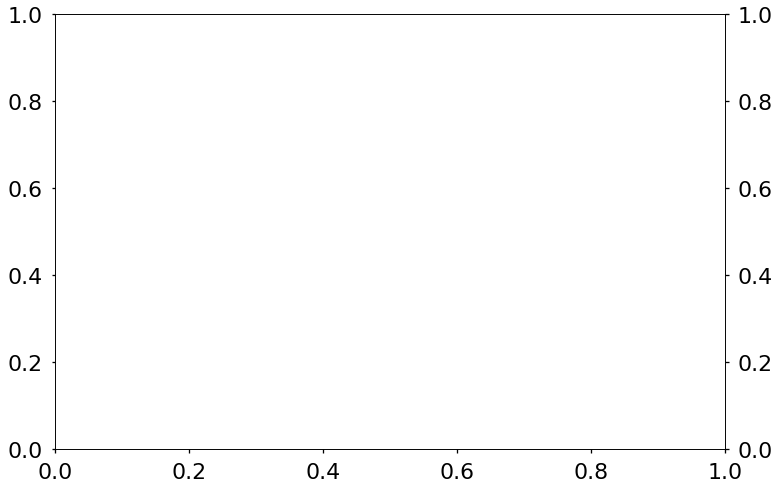

In [25]:
# r2_fig, (r2_ax, vol_ax) = mpl.pyplot.subplots(nrows=2, sharex=True)
r2_fig, r2_ax = mpl.pyplot.subplots()
r2_fig.set_size_inches((12, 8))
vol_ax = r2_ax.twinx()
# if freq == 'M':
#     hetero_r_squared.rolling(6).mean().plot(legend=False, ax=r2_ax)
# else:
data_2_plot = homo_r2_daily[['jumps', 'var_prem']].rolling(75).apply(np.mean)
r2_ax.plot(data_2_plot.jumps, color='red')
r2_ax.plot(data_2_plot.var_prem, color='black')
vol_ax.plot((data.quad.iloc[min_periods:]).rolling(75).sum().apply(np.sqrt), color='purple', label='vol') 
r2_ax.axhline(0, color='black')
r2_ax.axhline(1, color='black', linestyle='dashed')
r2_ax.yaxis.set_major_locator(ticker.FixedLocator([-10, -5, 0, 1]))
vol_ax.yaxis.set_major_locator(ticker.MaxNLocator(5))

legend1 = r2_ax.legend(loc='center right',bbox_to_anchor=(.2,.5), frameon=False, fontsize=65)
legend2 = vol_ax.legend(loc='center left',bbox_to_anchor=(1.05,.5), frameon=False, fontsize=65)

r2_ax.set_ylim([-10,2])
for text in legend1.texts + legend2.texts:
    text.set_visible(False)
r2_fig.savefig(fname='../doc/figures/return_predictability.pdf', transparent=True, bbox_inches='tight', 
               pad_inches=0, frameon=False)

In [26]:
pvalue_results.min()  * pvalue_results.count()

log_vol              2745.7975
diff_jumps           2747.9546
diff_jumps_inter     2747.9887
diffusion            2746.0854
jumps                2745.8665
var_prem             2742.8794
poly_vol             2748.0000
poly_vol_vix_quad    2748.0000
poly_vol_vix         2748.0000
jump_prop            2747.9528
dtype: float64

In [27]:
pvalue_results.mean()

log_vol              0.9999
diff_jumps           1.0000
diff_jumps_inter     1.0000
diffusion            0.9999
jumps                0.9999
var_prem             0.9994
poly_vol             1.0000
poly_vol_vix_quad    1.0000
poly_vol_vix         1.0000
jump_prop            1.0000
dtype: float64

In [28]:
## And the sharpe ratios are as follows.

In [29]:
data.daily_rtn.var() / data.quad.mean()

0.6971752501886307

In [30]:
homo_r_squared * 100

log_vol             -1.9970
diff_jumps          -2.2985
diff_jumps_inter    -2.7398
diffusion           -2.0960
jumps               -1.9437
var_prem            -3.0860
poly_vol            -3.3002
poly_vol_vix_quad   -4.3060
poly_vol_vix        -3.3309
jump_prop           -2.3097
dtype: float64

In [31]:
hetero_r_squared.mean() * 100

log_vol              14.0200
diff_jumps           13.9361
diff_jumps_inter     13.9574
diffusion            14.0478
jumps                13.9830
var_prem             13.9121
poly_vol             13.8853
poly_vol_vix_quad    12.1937
poly_vol_vix         13.7759
jump_prop            13.9602
dtype: float64

## Predicting $VIX_t^2 - \sigma_t^2 - \gamma_t^2$

In [32]:
var_prem_r2, var_prem_pvalue  = compute_mse(endog=data.var_prem,  exog=data[['log_diff', 'log_jumps',  'jump2', 
                                                                             'diff2', 'diff_jumps']], weights=None)

In [33]:
1 - (var_prem_r2 / data.var_prem.var())

0.9958100951361746

## Implied Sharpe Ratios

In [34]:
uncond_sharpe = data['daily_rtn'].mean() / data['daily_rtn'].std()

In [35]:
uncond_sharpe

0.011841239590554812

In [36]:
homo_sharpe_ratios = np.sqrt((uncond_sharpe**2 + homo_r_squared) / ( 1 - homo_r_squared))

/home/sangrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [37]:
hetero_sharpe_ratios = np.sqrt((uncond_sharpe**2 + hetero_r_squared.mean()) / ( 1 - hetero_r_squared.mean()))

In [38]:
hetero_sharpe_ratios

log_vol              0.4040
diff_jumps           0.4026
diff_jumps_inter     0.4030
diffusion            0.4045
jumps                0.4034
var_prem             0.4022
poly_vol             0.4018
poly_vol_vix_quad    0.3729
poly_vol_vix         0.3999
jump_prop            0.4030
dtype: float64

In [39]:
homo_sharpe_ratios * np.sqrt(np.sqrt(data.groupby(pd.Grouper(freq='A')).count().mean().iloc[0]))

log_vol             NaN
diff_jumps          NaN
diff_jumps_inter    NaN
diffusion           NaN
jumps               NaN
var_prem            NaN
poly_vol            NaN
poly_vol_vix_quad   NaN
poly_vol_vix        NaN
jump_prop           NaN
dtype: float64

In [40]:
hetero_sharpe_ratios * np.sqrt(np.sqrt(data.groupby(pd.Grouper(freq='A')).count().mean().iloc[0]))

log_vol              1.6062
diff_jumps           1.6006
diff_jumps_inter     1.6021
diffusion            1.6081
jumps                1.6038
var_prem             1.5990
poly_vol             1.5972
poly_vol_vix_quad    1.4824
poly_vol_vix         1.5899
jump_prop            1.6022
dtype: float64

In [41]:
uncond_sharpe * np.sqrt(np.sqrt(data.groupby(pd.Grouper(freq='A')).count().mean().iloc[0]))

0.04707710673809351